In [1]:
import random
import math
import networkx as nx
import pandas as pd
from ndlib.models.DiffusionModel import DiffusionModel
import numpy as np
from scipy.stats import kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 2.1 Opnion dynamics

In [2]:
class Opinion_dynamic(DiffusionModel):
    # initialize
    def __init__(self, graph, epsilon, mu):
        self.epsilon = epsilon
        self.mu = mu
        self.graph = graph
        self.status = {}
        self.iteration_times = 0
        for i in range(self.graph.number_of_nodes()):
            self.status[i] = random.random()           
        self.opinions = {}
        for n in self.status.keys():
            self.opinions[n] = [self.status[n]]
        
    #  opinion dymanic      
    def iteration(self, node_status=True):
        self.iteration_times += 1
        stat_dic = {}
        # select a random node
        n1 = list(self.graph.nodes)[np.random.randint(0,self.graph.number_of_nodes())]
        # select all of the node's neighbours (no digraph possible)
        neighbours = list(self.graph.neighbors(n1))
        while len(neighbours) == 0:
            n1 = list(self.graph.nodes)[np.random.randint(0,self.graph.number_of_nodes())]
            neighbours = list(self.graph.neighbors(n1))            
        # select second nodebased on selection probabilities above
        n2 = np.random.randint(0, len(neighbours))
        n2 = neighbours[n2]
        # update status of n1 and n2
        diff = np.abs(self.status[n1]-self.status[n2])
        if diff < self.epsilon:
            self.status[n1] += self.mu * (self.status[n2] - self.status[n1])
            self.status[n2] += self.mu * (self.status[n1] - self.status[n2])
        # store the oponions
        for n in self.status.keys():
            self.opinions[n].append(self.status[n])
                

100%|██████████| 50000/50000 [00:13<00:00, 3818.20it/s]


Text(0,0.5,'opinions')

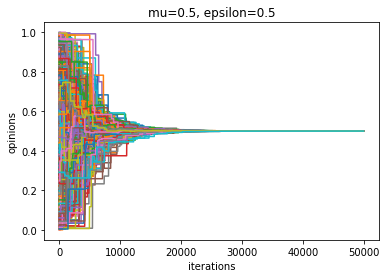

In [3]:
# Network topology
g = nx.barabasi_albert_graph(1000, 4)
# Model selection
model = Opinion_dynamic(g, epsilon=0.5, mu=0.5)
# Simulation execution
iterations = model.iteration_bunch(50000)
# plot
for i in range(len(model.opinions)):
    plt.plot(model.opinions[i])
    
plt.title("mu=0.5, epsilon=0.5")
plt.xlabel("iterations")
plt.ylabel("opinions")

100%|██████████| 50000/50000 [00:13<00:00, 3797.64it/s]


Text(0,0.5,'opinions')

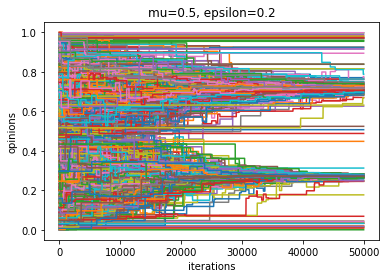

In [5]:
# Network topology
g = nx.barabasi_albert_graph(1000, 4)
# Model selection
model = Opinion_dynamic(g, epsilon=0.2, mu=0.5)
# Simulation execution
iterations = model.iteration_bunch(50000)
# plot
for i in range(len(model.opinions)):
    plt.plot(model.opinions[i])
    
plt.title("mu=0.5, epsilon=0.2")
plt.xlabel("iterations")
plt.ylabel("opinions")

100%|██████████| 50000/50000 [00:13<00:00, 3808.65it/s]


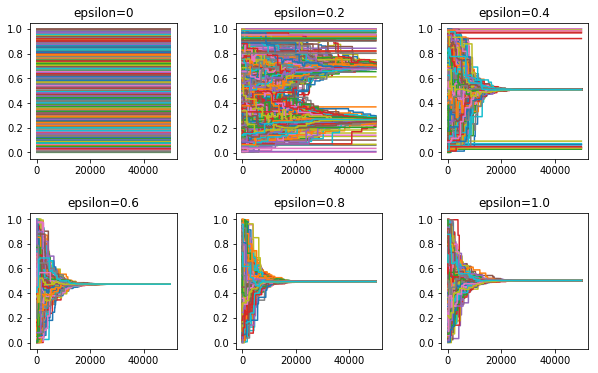

In [6]:
# initialize subplots
fig,axes=plt.subplots(2,3,figsize=(10, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
ax1=axes[0,0]
ax2=axes[0,1]
ax3=axes[0,2]
ax4=axes[1,0]
ax5=axes[1,1]
ax6=axes[1,2]

# plot 1
g = nx.barabasi_albert_graph(1000, 4)
model = Opinion_dynamic(g, epsilon=0, mu=0.5)
iterations = model.iteration_bunch(50000)
for i in range(len(model.opinions)):
    ax1.plot(model.opinions[i])
ax1.set_title("epsilon=0")
    
# plot 2
model = Opinion_dynamic(g, epsilon=0.2, mu=0.5)
iterations = model.iteration_bunch(50000)
for i in range(len(model.opinions)):
    ax2.plot(model.opinions[i])
ax2.set_title("epsilon=0.2")

# plot 3
model = Opinion_dynamic(g, epsilon=0.4, mu=0.5)
iterations = model.iteration_bunch(50000)
for i in range(len(model.opinions)):
    ax3.plot(model.opinions[i])
ax3.set_title("epsilon=0.4")

# plot 4
model = Opinion_dynamic(g, epsilon=0.6, mu=0.5)
iterations = model.iteration_bunch(50000)
for i in range(len(model.opinions)):
    ax4.plot(model.opinions[i])
ax4.set_title("epsilon=0.6")

# plot 5
model = Opinion_dynamic(g, epsilon=0.8, mu=0.5)
iterations = model.iteration_bunch(50000)
for i in range(len(model.opinions)):
    ax5.plot(model.opinions[i])
ax5.set_title("epsilon=0.8")

# plot 6
model = Opinion_dynamic(g, epsilon=1, mu=0.5)
iterations = model.iteration_bunch(50000)
for i in range(len(model.opinions)):
    ax6.plot(model.opinions[i])
ax6.set_title("epsilon=1.0")
plt.show()

# 2.2 ABM for prediction markets

In [7]:
class Prediction_Market(DiffusionModel):
    # initialize
    def __init__(self, graph, epsilon, mu, T, gamma, pi):
        self.epsilon = epsilon
        self.mu = mu
        self.graph = graph
        self.status = {}
        self.iteration_times = 0
        for i in range(self.graph.number_of_nodes()):
            self.status[i] = random.random()           

        self.T = T
        self.gamma = gamma
        self.pi = pi
        self.price = []
        self.tau = self.T
        
    def iteration(self, node_status=True):
        # choose random v
        v = random.normalvariate(0, math.sqrt(0.05))
        # calculate P
        if self.tau == self.T:
            P = 1
        else:
            P = pow(self.T - self.tau, -self.gamma)
        # calculate ED
        ED = 0
        for i in random.sample(self.graph.nodes(), math.floor(self.graph.number_of_nodes() * P)):
            D = self.status[i] - self.pi
            ED += abs(v) * D
        # update pi
        if ED >= 0:
            self.pi = min(1, self.pi + ED)
        else:
            self.pi = max(0, self.pi + ED)
        self.tau -= 1
        self.price.append(self.pi)
        # opinion dynamic
        for i in range(0,100):
            # select a random node
            n1 = list(self.graph.nodes)[np.random.randint(0, self.graph.number_of_nodes())]
            # select all of the node's neighbours (no digraph possible)
            neighbours = list(self.graph.neighbors(n1))
            if len(neighbours) == 0:
                continue
            # select second nodebased on selection probabilities above
            n2 = np.random.randint(0, len(neighbours))
            n2 = neighbours[n2]
            # update status of n1 and n2
            diff = np.abs(self.status[n1]-self.status[n2])
            if diff < self.epsilon:
                self.status[n1] += self.mu * (self.status[n2] - self.status[n1])
                self.status[n2] += self.mu * (self.status[n1] - self.status[n2])
        self.iteration_times += 1  

100%|██████████| 100/100 [00:00<00:00, 371.50it/s]


Text(0,0.5,'price')

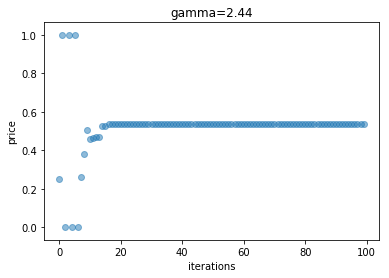

In [8]:
# Network topology
g = nx.barabasi_albert_graph(1000, 4)
# Model selection
model = Prediction_Market(g, epsilon=0.5, mu=0.5, T=100, pi=0.5, gamma=2.44)
# Simulation execution
iterations = model.iteration_bunch(model.T)
iter_step = range(model.T)
price_list = model.price
# plot 
plt.scatter(iter_step, price_list,alpha=0.5)
plt.title("gamma=2.44")
plt.xlabel("iterations")
plt.ylabel("price")

100%|██████████| 100/100 [00:00<00:00, 336.45it/s]


Text(0,0.5,'price')

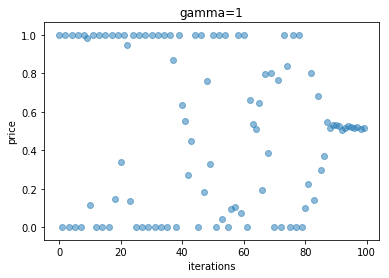

In [11]:
# Network topology
g = nx.barabasi_albert_graph(1000, 4)
# Model selection
model = Prediction_Market(g, epsilon=0.5, mu=0.5, T=100, pi=0.5, gamma=1)
# Simulation execution
iterations = model.iteration_bunch(model.T)
iter_step = range(model.T)
price_list = model.price
# plot 
plt.scatter(iter_step, price_list,alpha=0.5)
plt.title("gamma=1")
plt.xlabel("iterations")
plt.ylabel("price")

100%|██████████| 100/100 [00:00<00:00, 373.28it/s]


Text(0,0.5,'price')

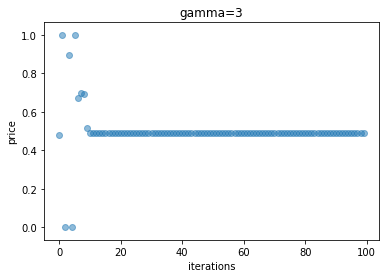

In [20]:
# Network topology
g = nx.barabasi_albert_graph(1000, 4)
# Model selection
model = Prediction_Market(g, epsilon=0.5, mu=0.5, T=100, pi=0.5, gamma=3)
# Simulation execution
iterations = model.iteration_bunch(model.T)
iter_step = range(model.T)
price_list = model.price
# plot 
plt.scatter(iter_step, price_list,alpha=0.5)
plt.title("gamma=3")
plt.xlabel("iterations")
plt.ylabel("price")

/Users/zhongshilei/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/zhongshilei/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'density')

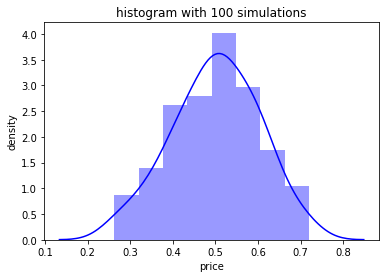

In [21]:
# Network topology
g = nx.barabasi_albert_graph(1000, 4)
# Model selection

# Simulation execution
end_price = []
for _ in range(100):
    model = Prediction_Market(g, epsilon=0.5, mu=0.5, T=100, pi=0.5, gamma=2.44)
    for i in range(model.T):
        model.iteration()
    end_price.append(model.price[-1])
sns.distplot(end_price,color="b",norm_hist=False)
plt.title("histogram with 100 simulations")
plt.xlabel("price")
plt.ylabel("density")

Text(0,0.5,'price')

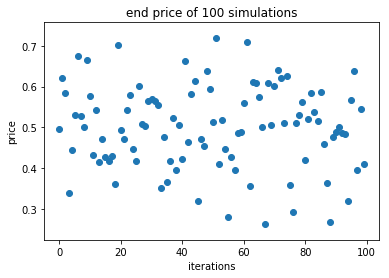

In [22]:
plt.scatter(range(100),end_price)
plt.title("end price of 100 simulations")
plt.xlabel("iterations")
plt.ylabel("price")

# 2.3 Validation 

In [23]:
# read file
prediction = pd.read_csv("dataprediction.csv", header=0, sep=",")
# calculate unique markets
market_list = list(prediction["id"].unique())
num = len(market_list)
print("Total number of unique markets: " + str(num))

Total number of unique markets: 3385


In [24]:
# calculate durations
duration = pd.DataFrame(prediction["id"].unique(), columns=["id"])
duration_days = []
for market in market_list:
    duration_days.append(len(prediction[prediction["id"] == market]["date"]))
duration["duration_days"] = duration_days
duration.head()

,id,duration_days
0,433,28
1,434,28
2,435,655
3,436,655
4,437,655


In [25]:
id_list = list(prediction["id"].unique())
duration_dic = {}
for i,row in duration.iterrows():
    duration_dic[row[0]] = row[1]
# store CloseSharePrice
k_emp_dic = {}
for i in market_list:
    k_emp_dic[i] = kurtosis(list(prediction[prediction["id"] == i]["CloseSharePrice"]))
# store duration
duration_market = {}
durations = list(duration["duration_days"].unique())
for d in durations:
    duration_market[d] = list(duration[duration["duration_days"] == d]["id"])

In [26]:
epsilon_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
mu_list = [0.1,0.2,0.3,0.4]
m = 0.1
for e in epsilon_list:
    with open("simulation.csv", "a+") as file1:
        file1.write("mu = " + str(m) + ", " + "epsilon = " + str(e) + "\n")
    for i in tqdm.tqdm(duration_dic.keys()):
        # Network topology
        duration_T = duration_dic[i]
        g = nx.barabasi_albert_graph(1000, 4)
        # Model selection
        model = Prediction_Market(g, epsilon=e, mu=m, T=duration_T, pi=0.5, gamma=2.44)
        # Simulation execution
        for _ in range(model.T):
            model.iteration()
        return_list = []
        for j in range(1,len(model.price)):
            return_list.append(model.price[j]-model.price[j-1])
        # store the results of each simulation
        with open("simulation.csv", "a+") as file1:
            file1.write(str(i) + " " + str(return_list) + "\n")
        # store k_sim
        with open("k_sim.csv", "a+") as file2:
            file2.write(str(m)+ "," + str(e) + "," + str(i) + "," + str(duration_T) + "," + str(kurtosis(return_list)) + "\n")
        # store the average return 
        if len(return_list) != 0:
            with open("return.csv", "a+") as file3:
                file3.write(str(m)+ "," + str(e) + "," + str(i) + "," + str(duration_T) + "," + str(np.average(return_list)) + "\n")

In [27]:
m = 0.2
for e in epsilon_list:
    with open("simulation.csv", "a+") as file1:
        file1.write("mu = " + str(m) + ", " + "epsilon = " + str(e) + "\n")
    for i in duration_dic.keys():
        duration_T = duration_dic[i]
        # Network topology
        g = nx.barabasi_albert_graph(1000, 4)
        # Model selection
        model = Prediction_Market(g, epsilon=e, mu=m, T=duration_T, pi=0.5, gamma=2.44)
        # Simulation execution
        for _ in range(model.T):
            model.iteration()
        return_list = []
        for j in range(1,len(model.price)):
            return_list.append(model.price[j]-model.price[j-1])
        # store the results of each simulation
        with open("simulation.csv", "a+") as file1:
            file1.write(str(i) + " " + str(return_list) + "\n")
        # store k_sim
        with open("k_sim.csv", "a+") as file2:
            file2.write(str(m)+ "," + str(e) + "," + str(i) + "," + str(duration_T) + "," + str(kurtosis(return_list)) + "\n")
        # store the average return 
        if len(return_list) != 0:
            with open("return.csv", "a+") as file3:
                file3.write(str(m)+ "," + str(e) + "," + str(i) + "," + str(duration_T) + "," + str(np.average(return_list)) + "\n")

In [28]:
m = 0.3
for e in epsilon_list:
    with open("simulation.csv", "a+") as file1:
        file1.write("mu = " + str(m) + ", " + "epsilon = " + str(e) + "\n")
    for i in tqdm.tqdm(duration_dic.keys()):
        duration_T = duration_dic[i]
        # Network topology
        g = nx.barabasi_albert_graph(1000, 4)
        # Model selection
        model = Prediction_Market(g, epsilon=e, mu=m, T=duration_T, pi=0.5, gamma=2.44)
        # Simulation execution
        for _ in range(model.T):
            model.iteration()
        return_list = []
        for j in range(1,len(model.price)):
            return_list.append(model.price[j]-model.price[j-1])
        # store the results of each simulation
        with open("simulation.csv", "a+") as file1:
            file1.write(str(i) + " " + str(return_list) + "\n")
        # store k_sim
        with open("k_sim.csv", "a+") as file2:
            file2.write(str(m)+ "," + str(e) + "," + str(i) + "," + str(duration_T) + "," + str(kurtosis(return_list)) + "\n")
        # store the average return             
        if len(return_list) != 0:
            with open("return.csv", "a+") as file3:
                file3.write(str(m)+ "," + str(e) + "," + str(i) + "," + str(duration_T) + "," + str(np.average(return_list)) + "\n")

In [29]:
m = 0.4
for e in epsilon_list:
    with open("simulation.csv", "a+") as file1:
        file1.write("mu = " + str(m) + ", " + "epsilon = " + str(e) + "\n")
    for i in tqdm.tqdm(duration_dic.keys()):
        duration_T = duration_dic[i]
        # Network topology
        g = nx.barabasi_albert_graph(1000, 4)
        # Model selection
        model = Prediction_Market(g, epsilon=e, mu=m, T=duration_T, pi=0.5, gamma=2.44)
        # Simulation execution
        for _ in range(model.T):
            model.iteration()
        return_list = []
        for j in range(1,len(model.price)):
            return_list.append(model.price[j]-model.price[j-1])
        # store the results of each simulation
        with open("simulation.csv", "a+") as file1:
            file1.write(str(i) + " " + str(return_list) + "\n")
        # store k_sim
        with open("k_sim.csv", "a+") as file2:
            file2.write(str(m)+ "," + str(e) + "," + str(i) + "," + str(duration_T) + "," + str(kurtosis(return_list)) + "\n")
        # store the average return 
        if len(return_list) != 0:
            with open("return.csv", "a+") as file3:
                file3.write(str(m)+ "," + str(e) + "," + str(i) + "," + str(duration_T) + "," + str(np.average(return_list)) + "\n")

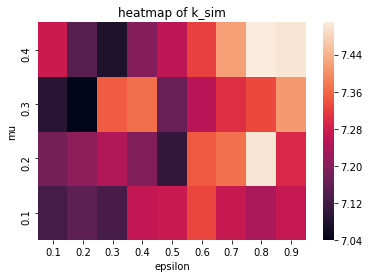

In [30]:
sim_data = pd.read_csv("k_sim.csv",sep=",",names=["mu","epsilon","market_id","duration","k_sim"])
# calculate averaged k_sim
averaged_k_sim = np.zeros([4,9])
for m in range(4):
    for e in range(9):
        averaged_k_sim[m][e] = np.mean(sim_data[(sim_data["mu"] == mu_list[m]) & (sim_data["epsilon"] == epsilon_list[e])]["k_sim"].fillna(0))        
# plot
fig = plt.figure()
sns_plot = sns.heatmap(averaged_k_sim,xticklabels=epsilon_list, yticklabels=mu_list).invert_yaxis()
plt.title("heatmap of k_sim")
plt.xlabel("epsilon")
plt.ylabel("mu")
plt.show()

In [32]:
# calculate objective function
for idx, row in sim_data.iterrows():
    with open("obj_fuction.csv", "a+") as file5:
        f = abs(row["k_sim"] - 39.31)
        file5.write(str(row["mu"])+ "," + str(row["epsilon"]) + "," + str(int(row["market_id"])) \
                    + "," + str(int(row["duration"])) + "," + str(f) + "\n")       

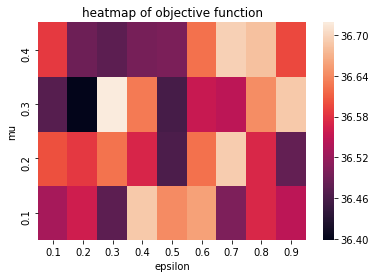

In [33]:
f_data = pd.read_csv("obj_fuction.csv",sep=",",names=["mu","epsilon","market_id","duration","f_score"])
# calculate averaged f score
averaged_f_score = np.zeros([4,9])
for m in range(4):
    for e in range(9):
        averaged_f_score[m][e] = np.mean(f_data[(f_data["mu"] == mu_list[m]) & (f_data["epsilon"] == epsilon_list[e])]["f_score"].fillna(0))
# plot
fig = plt.figure()
sns_plot = sns.heatmap(averaged_f_score,xticklabels=epsilon_list, yticklabels=mu_list).invert_yaxis()
plt.title("heatmap of objective function")
plt.xlabel("epsilon")
plt.ylabel("mu")
plt.show()                      